In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from feature_engine.selection import SmartCorrelatedSelection
import polars as pl


path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'utils')))
if (not (path2add in sys.path)) :
    sys.path.append(path2add)

import feature_engineering
from feature_engine.selection import SmartCorrelatedSelection


In [2]:
df = pl.read_csv("..\data\cleaned_df.csv")
callGraph = pl.read_json('..\data\supervised_call_graphs.json')

In [3]:
df.head(3)

,_id,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,num_sessions,num_users,num_unique_apis,source,classification,target
i64,str,f64,f64,f64,i64,str,f64,f64,f64,str,str,i64
0,"""1f2c32d8-2d6e-…",0.000812,0.004066,85.643243,5405,"""default""",1460.0,1295.0,451.0,"""E""","""normal""",0
1,"""4c486414-d4f5-…",0.000063,0.002211,16.166805,519,"""default""",9299.0,8447.0,302.0,"""E""","""normal""",0
2,"""7e5838fc-bce1-…",0.004481,0.015324,99.573276,6211,"""default""",255.0,232.0,354.0,"""E""","""normal""",0


In [4]:
callGraph.head(3)

_id,call_graph
str,list[struct[2]]
"""1f2c32d8-2d6e-…","[{""1f873432-6944-3df9-8300-8a3cf9f95b35"",""5862055b-35a6-316a-8e20-3ae20c1763c2""}, {""8955faa9-0e33-37ad-a1dc-f0e640a114c2"",""a4fd6415-1fd4-303e-aa33-bb1830b5d9d4""}, … {""016099ea-6f20-3fec-94cf-f7afa239f398"",""6fa8ad53-2f0d-3f44-8863-139092bfeda9""}]"
"""4c486414-d4f5-…","[{""016099ea-6f20-3fec-94cf-f7afa239f398"",""946e3ced-48a5-3de5-ad5a-1d20b1ab7eb5""}, {""a05a261f-128d-3cd8-a8e1-d6e52e161947"",""375c16ea-5f8d-32d5-8893-639d9b3a53d6""}, … {""68acdde8-bd53-39d1-9be0-fd67a281d7be"",""d7a53acc-eb6e-3f6c-b72e-9aefb54dd311""}]"
"""7e5838fc-bce1-…","[{""1f873432-6944-3df9-8300-8a3cf9f95b35"",""5862055b-35a6-316a-8e20-3ae20c1763c2""}, {""857c4b20-3057-30e0-9ca3-d6f5c3dbe4a6"",""857c4b20-3057-30e0-9ca3-d6f5c3dbe4a6""}, … {""016099ea-6f20-3fec-94cf-f7afa239f398"",""6fa8ad53-2f0d-3f44-8863-139092bfeda9""}]"


**Observation**
* Cleaned data already cotains engineered features

**Impact** 

* Do feature engineering on graph


In [5]:
callsProcessed = callGraph.with_columns(
    pl.col("call_graph").list.eval(
        pl.element().struct.rename_fields(["to", "from"])
    )
).explode("call_graph").unnest("call_graph")
callsProcessed.head(3)

_id,to,from
str,str,str
"""1f2c32d8-2d6e-…","""1f873432-6944-…","""5862055b-35a6-…"
"""1f2c32d8-2d6e-…","""8955faa9-0e33-…","""a4fd6415-1fd4-…"
"""1f2c32d8-2d6e-…","""85754db8-6a55-…","""85754db8-6a55-…"


In [6]:
graph_features = callsProcessed.group_by('_id').agg(
    pl.len().alias('n_connections'),
    pl.col('from'),
    pl.col('to')
).with_columns(
    pl.concat_list('from', 'to').list.unique().list.len().alias('n_unique_nodes')
).select([
    '_id',
    'n_connections',
    'n_unique_nodes'
])

graph_features.sample(3)

_id,n_connections,n_unique_nodes
str,u32,u32
"""6868cceb-fdad-…",293,86
"""2dbb73a4-ef22-…",1004,241
"""5fec83a8-02a3-…",1310,280


In [7]:
calls_processed = callsProcessed.with_columns(
    global_source_degrees = pl.len().over(pl.col('from')),
    global_dest_degrees = pl.len().over(pl.col('to')),
    local_source_degrees = pl.len().over(pl.col('from'), pl.col('_id')),
    local_dest_degrees = pl.len().over(pl.col('to'), pl.col('_id'))
)

calls_processed.sample(3)

_id,to,from,global_source_degrees,global_dest_degrees,local_source_degrees,local_dest_degrees
str,str,str,u32,u32,u32,u32
"""0c7a6b93-222a-…","""fce8aa27-6226-…","""fce8aa27-6226-…",423,410,2,3
"""f32e76df-89ce-…","""9ce37261-2d1b-…","""dfb8d9bf-1fba-…",1289,787,5,5
"""28660e09-7e96-…","""aadf8ca9-ffda-…","""12e5f3d2-9b45-…",1023,32071,3,77


In [8]:
node_features_agg = feature_engineering.aggregate_node_features(
    calls_processed,
    node_features=[
        "global_source_degrees",
        "global_dest_degrees",
        "local_source_degrees",
        "local_dest_degrees",
    ],
    by="_id",
)

graph_features = graph_features.join(node_features_agg, on="_id")
graph_features.head()

_id,n_connections,n_unique_nodes,avg_global_source_degrees,min_global_source_degrees,max_global_source_degrees,std_global_source_degrees,avg_global_dest_degrees,min_global_dest_degrees,max_global_dest_degrees,std_global_dest_degrees,avg_local_source_degrees,min_local_source_degrees,max_local_source_degrees,std_local_source_degrees,avg_local_dest_degrees,min_local_dest_degrees,max_local_dest_degrees,std_local_dest_degrees
str,u32,u32,f64,u32,u32,f64,f64,u32,u32,f64,f64,u32,u32,f64,f64,u32,u32,f64
"""de70a141-e24f-…",97,32,6316.690722,147,22416,8420.075494,7174.072165,188,32071,10598.369703,4.773196,1,9,2.608101,5.268041,1,14,4.04278
"""296e7d8a-36d0-…",2,3,1509.0,909,2109,848.528137,8158.0,4145,12171,5675.239026,1.0,1,1,0.0,1.0,1,1,0.0
"""3b1c1a33-b131-…",104,50,9415.673077,80,22416,9188.049923,7400.576923,111,32071,10217.242661,6.192308,1,15,5.79601,4.307692,1,14,4.143253
"""cbddfc89-6320-…",1,1,587.0,587,587,null,1223.0,1223,1223,null,1.0,1,1,null,1.0,1,1,null
"""9597a67f-d418-…",82,48,8796.682927,10,22416,8613.914129,8802.195122,3,32071,11023.888889,3.756098,1,10,3.37588,3.926829,1,14,4.658142


# Feature Selection

In [9]:
engineered_features = graph_features.columns[1:]
engineered_features

['n_connections',
 'n_unique_nodes',
 'avg_global_source_degrees',
 'min_global_source_degrees',
 'max_global_source_degrees',
 'std_global_source_degrees',
 'avg_global_dest_degrees',
 'min_global_dest_degrees',
 'max_global_dest_degrees',
 'std_global_dest_degrees',
 'avg_local_source_degrees',
 'min_local_source_degrees',
 'max_local_source_degrees',
 'std_local_source_degrees',
 'avg_local_dest_degrees',
 'min_local_dest_degrees',
 'max_local_dest_degrees',
 'std_local_dest_degrees']

In [10]:
null_counts = graph_features.null_count().transpose(include_header=True, header_name='col', column_names=['null_count'])
null_counts.filter(pl.col('null_count') > 0)

col,null_count
str,u32
"""std_global_sou…",42
"""std_global_des…",42
"""std_local_sour…",42
"""std_local_dest…",42


# Correlation Analysis

<Axes: >

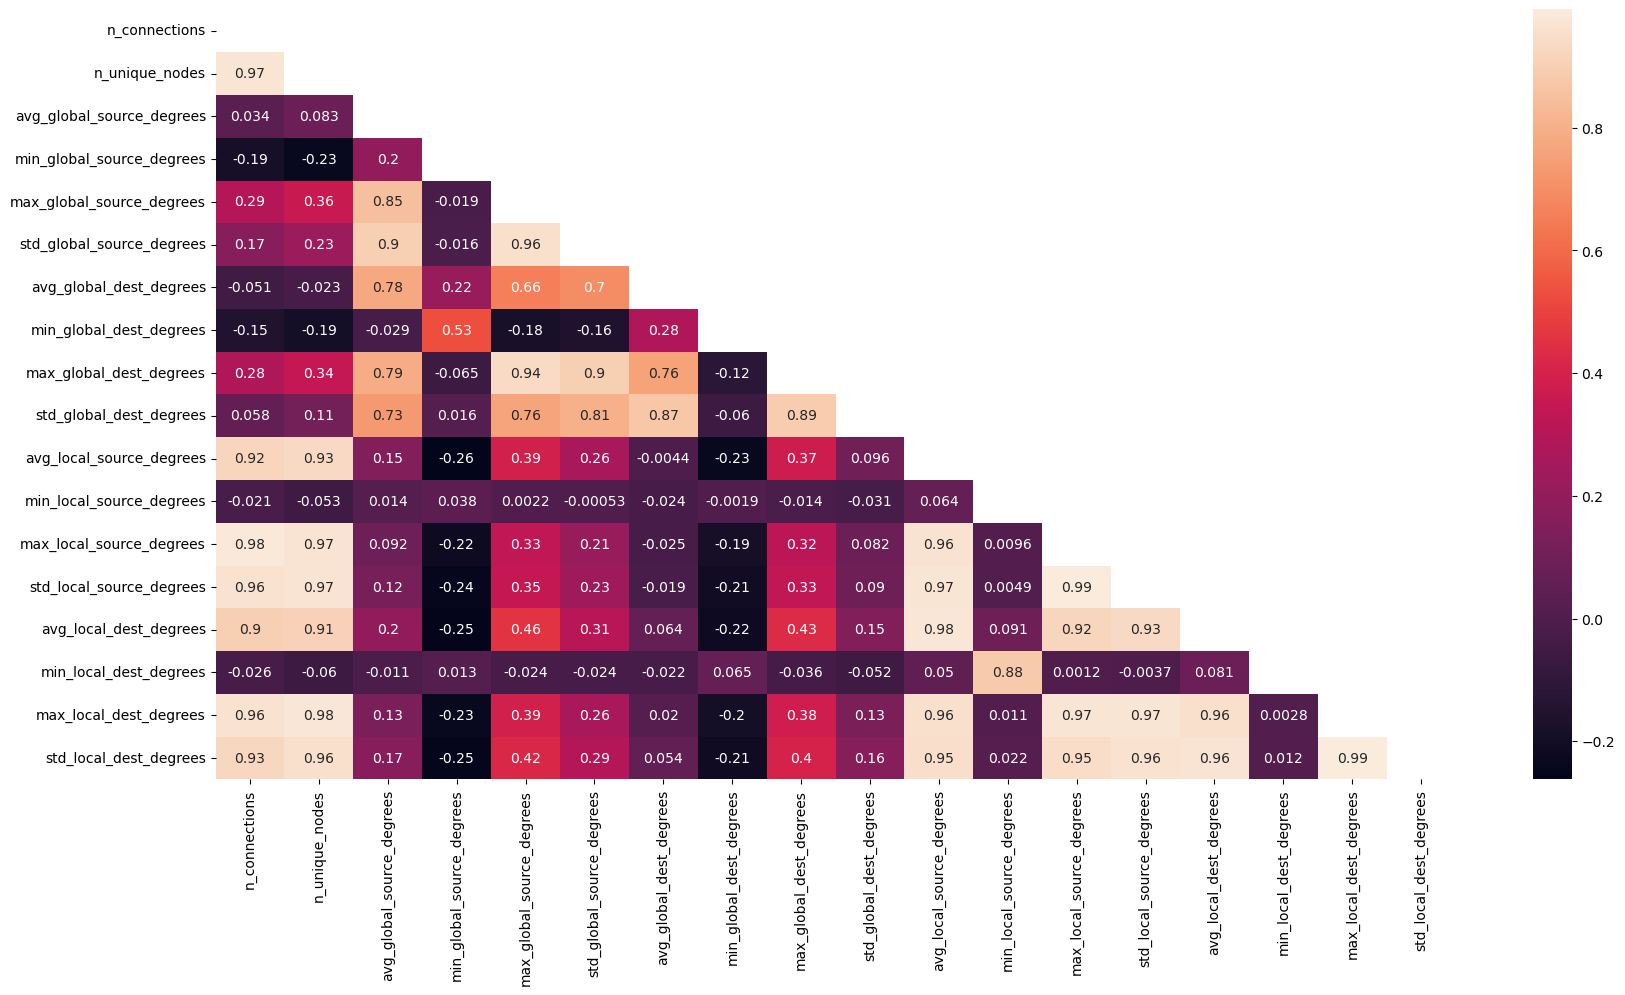

In [11]:
feature_corrs = graph_features.select(engineered_features).to_pandas().dropna().corr()
feature_corrs.index = feature_corrs.columns
matrix = np.triu(feature_corrs)
fig = plt.figure(figsize=(20, 10))
sns.heatmap(feature_corrs, annot=True, mask=matrix)

Lets use SmartCorrelationSelection to drop features

In [12]:
features_pd = graph_features.select(engineered_features).to_pandas().dropna()

tr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.95,
    missing_values="raise",
    selection_method="variance",
    estimator=None,
)

tr.fit(features_pd)

print('Features to drop:')
for f in tr.features_to_drop_:
    print(f)

Features to drop:
std_global_source_degrees
n_unique_nodes
max_local_dest_degrees
max_local_source_degrees
std_local_source_degrees
avg_local_source_degrees
avg_local_dest_degrees


**Observations:**

* Engineered features have groups of high correlation

**Impact**

* ['n_unique_nodes', 'std_global_dest_degrees', 'avg_local_source_degrees', 'max_local_source_degrees', 'avg_local_dest_degrees', 'max_local_dest_degrees' 'std_local_dest_degrees'] are dropped from the features list due to belonging to a high correlation set and having lower variance than the remaining feature

# EDA

In [13]:
engineeredFeatures = list(set(features_pd).difference(tr.features_to_drop_))

graph_features=graph_features.join(df.select(['_id', 'target']),  on='_id')

In [14]:
scores = []
for f in engineeredFeatures:
    print("Feature Analysis:", f)
    score = feature_engineering.feature_predictive_power(graph_features, f, "target")
    scores.append(score)

Feature Analysis: min_local_source_degrees
Predictive Power Score: 0.0


Feature Analysis: n_connections
Predictive Power Score: 0.3695000112056732


Feature Analysis: avg_global_source_degrees
Predictive Power Score: 0.13830000162124634


Feature Analysis: std_global_dest_degrees
Predictive Power Score: 0.26260000467300415


Feature Analysis: std_local_dest_degrees
Predictive Power Score: 0.3675999939441681


Feature Analysis: min_global_dest_degrees
Predictive Power Score: 0.28209999203681946


Feature Analysis: min_global_source_degrees
Predictive Power Score: 0.2768000066280365


Feature Analysis: avg_global_dest_degrees
Predictive Power Score: 0.1307000070810318


Feature Analysis: max_global_dest_degrees
Predictive Power Score: 0.027899999171495438


Feature Analysis: max_global_source_degrees
Predictive Power Score: 0.22689999639987946


Feature Analysis: min_local_dest_degrees
Predictive Power Score: 0.0


In [15]:
pd.Series(scores, index=engineeredFeatures).sort_values(ascending=False)

n_connections                0.3695
std_local_dest_degrees       0.3676
min_global_dest_degrees      0.2821
min_global_source_degrees    0.2768
std_global_dest_degrees      0.2626
max_global_source_degrees    0.2269
avg_global_source_degrees    0.1383
avg_global_dest_degrees      0.1307
max_global_dest_degrees      0.0279
min_local_source_degrees     0.0000
min_local_dest_degrees       0.0000
dtype: float32

Observations:

* Most of the engineered features have relatively highe predictiveness score
* The most predictive features are global
* Features with no predictive power measure minimum degrees of local graphs
* Relationships between engineered features and the target are not-linear

Impact
* *min_local_dest_degrees* and *min_local_source_degrees* can be dropped
* Tree based models need to be used to capture the engineered relationships

In [16]:

remaining_engineered_features = [f for f in engineeredFeatures if f not in ['min_local_dest_degrees', 'min_local_source_degrees']]
print('Final engineered featureset:')
print(remaining_engineered_features)

Final engineered featureset:
['n_connections', 'avg_global_source_degrees', 'std_global_dest_degrees', 'std_local_dest_degrees', 'min_global_dest_degrees', 'min_global_source_degrees', 'avg_global_dest_degrees', 'max_global_dest_degrees', 'max_global_source_degrees']


In [21]:
selected_features = [
    "max_global_source_degrees",
    "avg_global_source_degrees",
    "min_global_dest_degrees",
    "std_local_source_degrees",
    "max_global_dest_degrees",
    "min_global_source_degrees",
    "std_global_source_degrees",
    "n_connections",
    "avg_global_dest_degrees",
]

calls = (
    (
        pl.read_json("../data/supervised_call_graphs.json")
        .with_columns(
            pl.col("call_graph").list.eval(
                pl.element().struct.rename_fields(["from", "to"])
            )
        )
        .explode("call_graph")
        .unnest("call_graph")
    )
    .with_columns(
        global_source_degrees=pl.len().over(pl.col("from")),
        global_dest_degrees=pl.len().over(pl.col("to")),
        local_source_degrees=pl.len().over(pl.col("from"), pl.col("_id")),
        local_dest_degrees=pl.len().over(pl.col("to"), pl.col("_id")),
    )
    .pipe(feature_engineering.get_graph_features)
    .select(["_id"] + selected_features)
)

pl.read_parquet("../data/cleaned_df.parquet").join(
    calls, on="_id"
).write_parquet("../data/supervised_clean_data_w_features.parquet")